In [9]:
using DelimitedFiles
using DifferentialEquations
using Distributions
using StatsBase
using LinearAlgebra
using LsqFit
using Printf
using PyPlot; const plt = PyPlot
PyPlot.matplotlib.style.use("./paper.mplstyle");

include("utils.jl")
include("kernels.jl")
include("block_delay_kernel_dde.jl")
include("erlang_superpos_kernel.jl")
include("erlang_block_kernel.jl");
include("erlang_two_step_kernel.jl")

erlang_two_step_kernel_fp (generic function with 1 method)

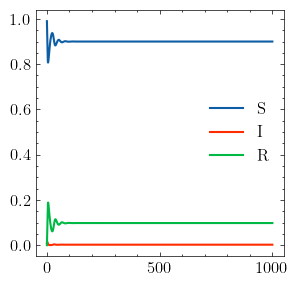

In [179]:
function sirs!(du, u, p, t)
    β, ρ, γ = p
    du[1] = - β * u[2] * u[1] + γ * u[3]
    du[2] = β * u[2] * u[1] - ρ * u[2]
    du[3] = ρ * u[2] - γ * u[3]
end

function solve_sirs(β, ρ, γ, I₀, t_max)
    p = (β, ρ, γ)
    u₀ = [1-I₀, I₀, 0]
    sol = solve(
        ODEProblem(sirs!, u₀, (0.0, t_max), p),
        RK4(),
        reltol = 1e-8
    )
    return sol
end

p = (β, ρ, γ) = (5, 4.5, 0.1)
I₀ = 0.01
t_max = 1000
sol = solve_sirs(p..., I₀, t_max)
fig, ax = plt.subplots()
# ax.set(xlim=(0, 100))
ax.plot(sol.t, sol[1, :], label = "S")
ax.plot(sol.t, sol[2, :], label = "I")
ax.plot(sol.t, sol[3, :], label = "R")
ax.legend()
display(fig)

# Kernels

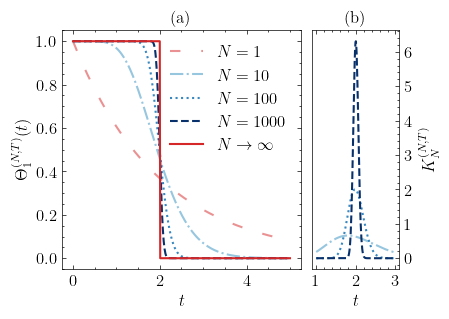

png file already exists. Skipping.
svg file already exists. Skipping.


In [60]:
T = 2
τ_range = 0:0.01:2.5*T
fig, (axl, axe) = plt.subplots(nrows = 1, ncols = 2, figsize = (4.5, 3.1), width_ratios = [0.75, 0.25])
fig.subplots_adjust(wspace=0)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 1),
    label = L"N = 1", color = "tab:red", alpha = 0.5,
    linestyle = (0, (5, 10))
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 10),
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 100),
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 1000),
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axl.plot(
    τ_range, Θ.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
axl.legend()

# axr.plot(
#     τ_range, -Kₘ.(τ_range, T/10, 10)/T,
#     label = L"N = 10", color = plt.get_cmap("Blues")(100),
#     linestyle = "-."
# )
# axr.plot(
#     τ_range, -Kₘ.(τ_range, T/100, 100)/T,
#     label = L"N = 100", color = plt.get_cmap("Blues")(170),
#     linestyle = ":"
# )
# axr.plot(
#     τ_range, -Kₘ.(τ_range, T/1000, 1000)/T,
#     label = L"N = 1000", color = plt.get_cmap("Blues")(255),
#     linestyle = "--"
# )
# axr.legend()

axe.set(xlabel=L"t", ylabel=L"K_{N}^{(N,T)}")
axe.yaxis.set_label_position("right")
axe.yaxis.tick_right()
ts = 1:0.01:3; T = 2
for (N, ls, c) in zip([10, 100, 1000], ["-.", ":", "--"], [100, 170, 255])#[end:-1:1]
    axe.plot(ts, Kₘ.(ts, T/N, N), linestyle = ls, c = plt.get_cmap("Blues")(c))
end

axl.set(
    xlabel = L"t", ylabel = L"\Theta_1^{(N, T)}(t)",
    box_aspect = 1,
    # title = L"\text{(a) }\Theta_T^{(N)}"
    title = L"\text{(a)}"
)
# axr.set(
#     # box_aspect = 1,
#     xlabel = L"t",
#     # title = L"\text{(b) }\mathrm{d}{\Theta}_T^{(N)}/\mathrm{d}t",
#     title = L"\text{(b)}"
#     # title = L"\text{(b) }\mathrm{d}\Theta_T^{(N)} / \mathrm{d}\tau"
# )
axe.set(
    title = L"\text{(b)}"
)
display(fig)
save_savefig(fig, "./img/block-kernel", png = true, svg = true)

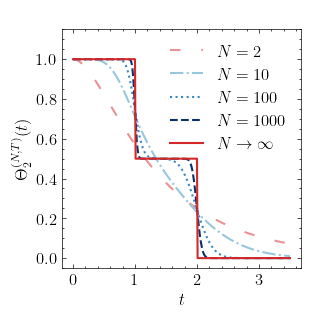

In [61]:
T = 2;
c(m, N) = m <= N/2 ? 1 : 0.5
Θ₂_alt(τ, T, N) = T / N * sum([c(m, N) * Kₘ(τ, T/N, m) for m in 1:N])
Θ₂(τ, T, N) = (0.5 * Θ_ker(τ, T/2, N) + 0.5 * Θ_ker(τ, T, N))
τ_range = 0:0.01:3.5

# fig, (axl, axe) = plt.subplots(nrows = 1, ncols = 2, figsize = (4.5, 3.1), width_ratios = [0.75, 0.25])
# fig.subplots_adjust(wspace=0)
fig, axl = plt.subplots(figsize = (3.1, 3.1))
axl.set(xlabel = L"t", ylabel = L"\Theta_2^{(N,T)}(t)", box_aspect = 1,
    title = " ",
    ylim = (-0.05, 1.15))
axl.plot(
    τ_range, Θ₂.(τ_range, T, 2),
    label = L"N = 2", color = "tab:red", alpha = 0.5,
    linestyle = (0, (5, 10))
)
axl.plot(
    τ_range, Θ₂.(τ_range, T, 10),
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axl.plot(
    τ_range, Θ₂.(τ_range, T, 100),
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axl.plot(
    τ_range, Θ₂.(τ_range, T, 1000),
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
Θ₂_lim(τ, T) = τ ≤ T ? (τ ≤ T / 2 ? 1 : 0.5) : 0
axl.plot(
    τ_range, Θ₂_lim.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
axl.legend()

# axe.set(xlabel=L"t", ylabel=L"K_{N}^{(N,T)}")
# axe.yaxis.set_label_position("right")
# axe.yaxis.tick_right()
# ts = 1:0.01:3; T = 2
# for (N, ls, c) in zip([10, 100, 1000], ["-.", ":", "--"], [100, 170, 255])#[end:-1:1]
#     axe.plot(ts, Kₘ.(ts, T/N, N), linestyle = ls, c = plt.get_cmap("Blues")(c))
# end
# axe.set(
#     title = L"\text{(b)}"
# )
display(fig)
save_savefig(fig, "./img/two-step-kernel", png = true)

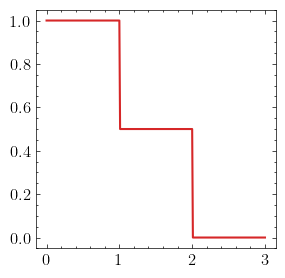

In [76]:
fig, ax = plt.subplots()
τ_range = 0:0.01:3
T = 2
ax.plot(
    τ_range, 0.5 * Θ.(τ_range, T/2) + 0.5 * Θ.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
display(fig)

# SIRS time delay system with step function block delay kernel (Hethcote et al. 1981)

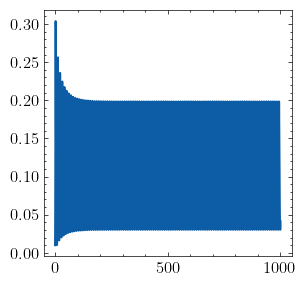

0.305244771656034
0.4926388580566674


In [11]:
p = (β, ρ, T) = (3, 1, 6)
I₀ = 0.01
t_max = 1000
sol = solve_step_function_kernel(p..., I₀, t_max)

println(pearson_skew(sol, 1, 200, t_max))
println(skew(sol, 1, 200, t_max))

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, sol[2, :])
display(fig)

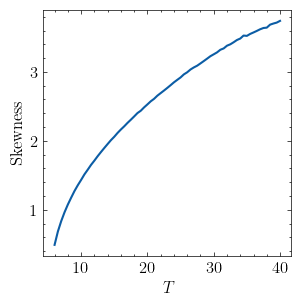

In [19]:
β, ρ = 3, 1
I₀ = 0.01
t_trans = 200; t_max = 5000

# X
Ts = 6:0.5:40
# Y
skews = [skew(solve_step_function_kernel(β, ρ, T, I₀, t_max), 1, t_trans, t_max) for T in Ts]

fig, ax = plt.subplots()
ax.set(xlabel = L"T", ylabel = "Skewness")
ax.plot(Ts, skews)
display(fig)

# Block delay kernel as Erlang Kernel sum

The dwell-time of individuals in the recovered compartment R is given by a block
kernel. With that the recovered compartment is given as a superposition
$$
    R = \sum_m R_m
$$

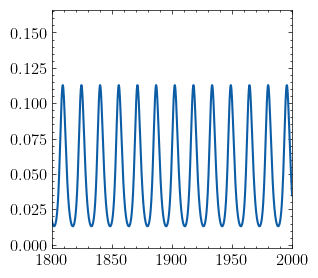

In [158]:
p = (β, ρ, T, N) = (2, 1, 9, 200)
I₀ = 0.01
t_max = 2000
sol = solve_erlang_block_kernel(β, ρ, T, N, I₀, t_max)

# println(pearson_skew(sol, 1, 300, t_max))
# println(skew(sol, 1, 3000, t_max))

fig, ax = plt.subplots()
ax.set(xlim=(1800, 2000))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, erlang_sum_kernel_R(sol))
display(fig)

In [50]:
function generate_skew_convergence(
        β::Real, ρ::Real, T::Real, N_max::Integer, t_trans::Real, t_max::Real;
        I₀ = 0.01
    )
    p = (β, ρ, T)
    N = N_onset = erlang_block_kernel_oscillation_onset(p...; N_max = N_max)
    dN = 1
    Ns = []
    while N <= N_max
        push!(Ns, N)
        N += dN
        dN += 1
    end
    skews = [skew(solve_erlang_block_kernel(p..., N, I₀, t_max), 1, t_trans, t_max; Δt = 0.01) for N in Ns]
    return Ns, skews
end;

# p = (β, ρ, T) = (2, 1, 16)
# I₀ = 0.01
# t_trans = 3000; t_max = 20000
# # Reference value -- step function kernel (sfk)
# skew_sfk = skew(solve_step_function_kernel(p..., I₀, t_max), 1, t_trans, t_max)
# # Increasingly sharp erlang sum kernels (esk)
# Ns, skews_esk = generate_skew_convergence(p..., 100, t_trans, t_max);

generate_skew_convergence (generic function with 1 method)

Skewness 1.135275086377799Skewness 0.9028046792527811Skewness 0.6703469297278891

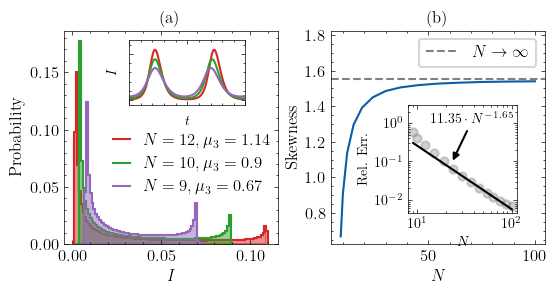

In [64]:
# parameters (β, ρ, T, N)
parameter_sets = [(2, 1, 16, 12), (2, 1, 16, 10), (2, 1, 16, 9)]
colors = ["tab:red", "tab:green", "tab:purple"]
t_shifts = [3, -11.6, -4.7]
I₀ = 0.01
t_max = 5000; t_trans = 300

# fig, (axl, axr) = plt.subplots(ncols = 2, figsize=(7.2, 3.2))
fig, (axl, axr) = plt.subplots(ncols = 2, figsize=(6.2, 3.1))
axl.set(xlabel = L"I", ylabel = "Probability", box_aspect = 1, title = "(a)")
inax = fig.add_axes([0.23, 0.6, 0.225/1.2, 0.25/1.2])
inax.set(xlim=(4500, 4550), ylim=(-0.01, 0.13))
inax.set_xlabel(L"t", fontsize = 10)
inax.set_ylabel(L"I", fontsize = 10)
inax.xaxis.set_ticklabels([])
inax.yaxis.set_ticklabels([])
for (p, c, t_shift) in zip(parameter_sets, colors, t_shifts)
    sol = solve_erlang_block_kernel(p..., I₀, t_max)
    inax.plot(sol.t .- t_shift, sol[1, :], c = c)
    μ₃ = skew(sol, 1, t_trans, t_max)
    print("Skewness ", μ₃)
    # print("Pearson ", pearson_skew(sol, 1, t_trans, t_max))
    hist = normalized_sol_hist(sol, 1, t_trans, t_max)
    axl.stairs(hist.weights, hist.edges[1], color = c, label = L"N = %$(p[end]), \mu_3 = %$(round(μ₃, digits = 2))")
    axl.fill_between(hist.edges[1][1:end-1], hist.weights, alpha = 0.5, step = "post", color = c)
end
axl.legend(bbox_to_anchor=(0.16,0.16), handlelength = 1)

p = (2, 1, 16)
I₀ = 0.01
t_trans = 500; t_max = 20000; N_max = 100
axr.set(
    box_aspect = 1,
    # xscale = "log", yscale = "log",
    xlabel = L"N", ylabel = "Skewness",
    ylim = (0.625, 1.825),
    title = "(b)"
)
# Reference value -- step function kernel (sfk)
skew_sfk = skew(solve_step_function_kernel(p..., I₀, t_max), 1, t_trans, t_max)
axr.axhline(skew_sfk, ls = "--", c = "gray", label = L"N \to \infty")
# Increasingly sharp erlang sum kernels (esk)
Ns, skews_esk = generate_skew_convergence(p..., N_max, t_trans, t_max);
axr.plot(Ns, skews_esk)
axr.legend(loc = "upper right", frameon = true)

inaxr = fig.add_axes([0.68, 0.25, 0.35/2, 0.35])
inaxr.set(
    box_aspect = 1,
    xscale = "log", yscale = "log",
    ylim = (4.5*10^(-3), 3)
)
inaxr.set_xlabel(L"N", fontsize = 10)
inaxr.set_ylabel("Rel. Err.", fontsize = 10)
inaxr.tick_params(axis="both", which="major", labelsize=10)
rel_err = (skew_sfk .- skews_esk)/skew_sfk
inaxr.scatter(Ns, rel_err, color = "gray", alpha = 0.35)
@. m(N, params) = params[1] * (1 / float(N))^(params[2])
pl_fit = curve_fit(m, Ns[7:end], rel_err[7:end], [1.1, 1.1])
inaxr.plot(Ns, m(Ns, pl_fit.param), c = "black") # L"%$(round((pl_fit.param)[1], digits=2)) \cdot N^{-%$(round((pl_fit.param)[2], digits=2))}"
inaxr.annotate(L"%$(round((pl_fit.param)[1], digits=2)) \cdot N^{-%$(round((pl_fit.param)[2], digits=2))}", fontsize = 10,
        (2.3*10, 9*10^(-2)), (1.4*10, 1), color = "black", arrowprops = Dict("arrowstyle" => "-|>", "color" => "black"))
save_savefig(fig, "./img/skewness", svg = true, png = true)
display(fig)

## Eigenvalues

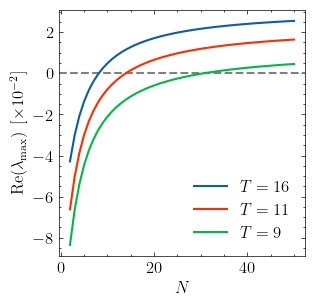

In [9]:
Ns = 2:50
# Parameters are (β, ρ, T)
# param_sets = [(2, 1/0.8, 16), (1, 1/5, 30)]
param_sets = [(2, 1, 16), (2, 1, 11), (2, 1, 9)]

fig, ax = plt.subplots()
ax.set(
    xlabel = L"N", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1
)
ax.axhline(0.0, ls = "--", c = "gray")
for p in param_sets
    ax.plot(Ns, λ_max.(erlang_block_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
            label = L"T = %$(p[end])")
end
ax.legend()
display(fig)

png file already exists. Skipping.


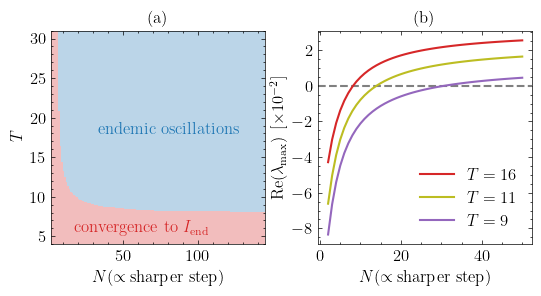

In [50]:
## PLOT FOR POSTER ##

fig, (axl, axr) = plt.subplots(figsize=(6.2, 3.1), ncols = 2)
# fig.subplots_adjust(wspace = 0.05)
axr.set(
    xlabel = L"N (\propto \text{sharper step})", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1, title = "(b)"
)
Ns = 2:50
axr.axhline(0.0, ls = "--", c = "gray")
parameter_sets = [(2, 1, 16), (2, 1, 11), (2, 1, 9)] # Parameters are (β, ρ, T)
colors = ["tab:red", "tab:olive", "tab:purple"]
for (p, c) in zip(parameter_sets, colors)
    axr.plot(Ns, λ_max.(erlang_block_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
            label = L"T = %$(p[end])", c = c)
end
axr.legend()


Ns = 2:1:150
Ts = 1:0.1:35
β, ρ = 2, 1

# https://groups.google.com/g/julia-users/c/83Pfg9HGhGQ/m/9G_0wi-GBQAJ
# z = [λ_max(erlang_block_kernel_jacobian(β, ρ, T, N)) for T in Ts, N in Ns] # CALCULATION
# sign_change = (diff(sign.(z), dims = 1) .!= 0)[:, 1:end-1] + (diff(sign.(z), dims = 2) .!= 0)[1:end-1, :]
z = readdlm("./data/block-delay-kernel/oscillation-onset-heatmap.dat", comments = true)

axl.set(
    box_aspect = 1,
    xlabel = L"N (\propto \text{sharper step})", ylabel = L"T",
    ylim = (4, 31), xlim = (2, 145),
    title = "(a)"
)
# Heatmap Arguments are name, red, green, blue and alpha codes. Tuples resemble
# (x, y0, y1), where x is input to colormap, y0 is end point of interpolation
# from last color and y1 is start point of interpolation to next color (y0 and
# y1 allow gaps in the colormap). Interpolation here between tab:red (x=0) and
# tab:blue (x=1).
# tab:blue: (0.1216, 0.4667, 0.7059)
# tab:red: (0.8392, 0.1529, 0.1569)
cm_alpha = 0.3
hm_cmap = plt.ColorMap("cm", [(0.0, 0.8392, 0.8392), (1.0, 0.1215, 0.1215)], [(0.0, 0.1529, 0.1529), (1.0, 0.4666, 0.4666)], [(0.0, 0.1529, 0.1529), (1.0, 0.7058, 0.7058)], [(0.0, cm_alpha, cm_alpha), (1.0, cm_alpha, cm_alpha)], 2)
z_scaled = z ./ 10^(-2)
hm = axl.pcolormesh(
    Ns, Ts, z_scaled,
    cmap = hm_cmap,
    vmin = - maximum(z_scaled), # Colormap symmetric, required to center at zero.
    rasterized = true
)
axl.text(33, 18, "endemic oscillations", c = "tab:blue")
axl.text(17, 5.5, "convergence to " * L"I_\mathrm{end}", c = "tab:red")

save_savefig(fig, "./img/eigenvalues", png = true)
save_savefig(fig, "./img/eigenvalues", svg = true; dpi = 100)
display(fig)

# Two step block delay

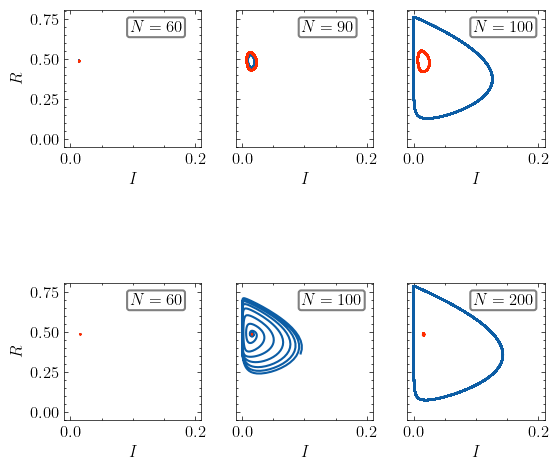

png file already exists. Skipping.
svg file already exists. Skipping.


In [2]:
function plot_sol_from_u0(p, t_max, t_trans, u₀, ax; Δu₀=nothing, kwargs...)
    N = p[4]; Δu₀ = Δu₀ == nothing ? zeros(N+1) : Δu₀
    sol = solve(ODEProblem(erlang_two_step_kernel!, u₀+Δu₀, (0.0, t_max), p), RK4(), reltol = 1e-5)
    I = sol[1, t_trans:end]; R = erlang_two_step_kernel_R(sol, N)[t_trans:end]
    ax.plot(I, R; kwargs...)
    return sol
end

t_max = 6000
t_trans = 3000

# fig, ax = plt.subplots(); ax.set(xlim=(-0.01, 0.2), ylim=(-0.01, 1.0))
fig, axs = plt.subplots(figsize = (6.2, 6.5), ncols = 3, nrows = 2, sharey = true)
axs_t = axs[1, :]; axs_b = axs[2, :]

xlim = (-0.01, 0.21); ylim = (-0.05, 0.805)
for ax in axs
    ax.set(box_aspect = 1, xlim = xlim, ylim = ylim, xlabel = L"I")
end
axs_t[1].set(ylabel = L"R")
axs_b[1].set(ylabel = L"R")

p = (β, ρ, T) = (2, 1, 45) # N = 108
for (N, ax) in zip([60, 90, 100], axs_t)
    # FP
    I₀_fp = erlang_two_step_kernel_fp(β, ρ, T)
    Rₘ₀_fp = ρ * T / N * I₀_fp
    u₀_fp = fill(Rₘ₀_fp, N+1); u₀_fp[1] = I₀_fp

    I₀ = 0.01
    # Rₘ₀ = 0.99 * 4/(3*N)
    u₀ = zeros(N+1); u₀[1] = I₀;
    plot_sol_from_u0((p..., N), t_max, t_trans, u₀, ax)
    Δu₀ = rand(N+1); Δu₀ /= norm(Δu₀)
    Δu₀ *= 0.01
    # Δu₀ = zeros(N+1); Δu₀[1] = 0.1
    plot_sol_from_u0((p..., N), t_max, t_trans, u₀_fp, ax; Δu₀)

    ax.text(0.095, 0.67, L"N = %$(N)", bbox=Dict("edgecolor" => "gray", "facecolor" => "none", "boxstyle" => "round,pad=0.15"))
end

p = (β, ρ, T) = (2, 1, 40) # N = 108
for (N, ax) in zip([60, 100, 200], axs_b)
    # FP
    I₀_fp = erlang_two_step_kernel_fp(β, ρ, T)
    Rₘ₀_fp = ρ * T / N * I₀_fp
    u₀_fp = fill(Rₘ₀_fp, N+1); u₀_fp[1] = I₀_fp

    I₀ = 0.01
    # Rₘ₀ = 0.99 * 4/(3*N)
    u₀ = zeros(N+1); u₀[1] = I₀;
    plot_sol_from_u0((p..., N), t_max, t_trans, u₀, ax)
    Δu₀ = rand(N+1); Δu₀ /= norm(Δu₀)
    Δu₀ *= 0.01
    # Δu₀ = zeros(N+1); Δu₀[1] = 0.1
    plot_sol_from_u0((p..., N), t_max, t_trans, u₀_fp, ax; Δu₀)

    ax.text(0.095, 0.67, L"N = %$(N)", bbox=Dict("edgecolor" => "gray", "facecolor" => "none", "boxstyle" => "round,pad=0.15"))
end

display(fig)
save_savefig(fig, "./img/two-step-multistability", png = true, svg = true)
# FP for cₘ(m) = m <= N/2 ? 1 : 0.5
# @printf("ana: I = %.4f, R = %.4f\n", erlang_two_step_kernel_fp(β, ρ, T), erlang_two_step_kernel_R(u₀_fp, N)[1])
# @printf("num: I = %.4f\n", sol[1, end])

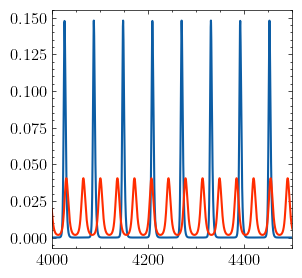

In [53]:
p = (β, ρ, T, N) = 2, 1, 50, 200
t_max = 6000
t_trans = 3000

# FP
I₀_fp = erlang_two_step_kernel_fp(β, ρ, T)
Rₘ₀_fp = ρ * T / N * I₀_fp
u₀_fp = fill(Rₘ₀_fp, N+1); u₀_fp[1] = I₀_fp

I₀ = 0.01
# Rₘ₀ = 0.99 * 4/(3*N)
u₀ = zeros(N+1); u₀[1] = I₀;

Δu₀ = rand(N+1); Δu₀ /= norm(Δu₀)
Δu₀ *= 0.01
# Δu₀ = zeros(N+1); Δu₀[1] = 0.1

function solve_at_init(p, t_max, t_trans, u₀; ax=nothing, Δu₀=nothing)
    N = p[4]; Δu₀ = Δu₀ == nothing ? zeros(N+1) : Δu₀
    sol = solve(ODEProblem(erlang_two_step_kernel!, u₀+Δu₀, (0.0, t_max), p), RK4(), reltol = 1e-5)
    I = sol[1, t_trans:end]; R = erlang_two_step_kernel_R(sol, N)[t_trans:end]
    if !isnothing(ax)
        ax.plot(I, R)
    end
    return sol.t[t_trans:end], I, R
end


# NOTE: Period of small LC is roughly 4045 - 4077 = 32
#       Period of large LC is roughly 4066 - 4011 = 55
fig = plt.figure()
plt.xlim(4000, 4500)
t, I, R = solve_at_init(p, t_max, t_trans, u₀)
plt.plot(t, I)
t, I, R = solve_at_init(p, t_max, t_trans, u₀_fp; Δu₀ = Δu₀)
plt.plot(t, I)

# One step model
# NOTE: For the same parameter values, the Hopf LC of the one step model
#       shows similar topology and period as the large LC of the two-step model.
# sol = solve_erlang_block_kernel(β, ρ, T, N, I₀, t_max)
# plt.plot(sol.t .+ 29, sol[1, :])

display(fig)

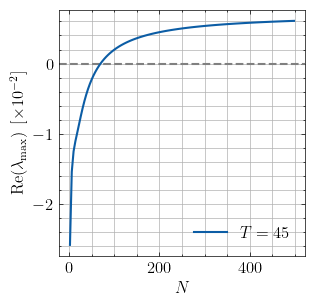

In [135]:
# FIXME: Max eigenvalue prediction correct for T = 50, but not for T = 30
# Parameters are (β, ρ, T)
p = (β, ρ, T) = (2, 1, 45)

Ns = 2:4:500
fig, ax = plt.subplots()
ax.set(
    xlabel = L"N", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]",
    box_aspect = 1
)
ax.axhline(0.0, ls = "--", c = "gray")
ax.plot(Ns, λ_max.(erlang_two_step_kernel_jacobian.(p..., Ns)) ./ 10^(-2),
        label = L"T = %$(p[end])")
ax.legend()
ax.grid(which="both")
display(fig)

png file already exists. Skipping.


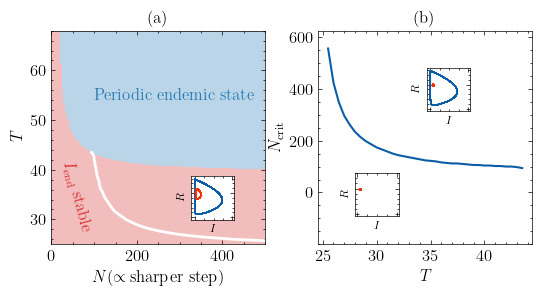

In [41]:
β, ρ = 2, 1
Ns = 2:4:500
Ts = 25:0.1:70

# https://groups.google.com/g/julia-users/c/83Pfg9HGhGQ/m/9G_0wi-GBQAJ
# z = [λ_max(erlang_two_step_kernel_jacobian(β, ρ, T, N)) for T in Ts, N in Ns]
# sign_change = (diff(sign.(z), dims = 1) .!= 0)[:, 1:end-1] + (diff(sign.(z), dims = 2) .!= 0)[1:end-1, :]

z = readdlm("./data/two-step-kernel/new-oscillation-onset-heatmap.dat", comments = true)

fig, (axl, axr) = plt.subplots(figsize = (6.2, 3.1), ncols = 2)
axl.set(
    box_aspect = 1,
    xlabel = L"N (\propto \text{sharper step})", ylabel = L"T",
    xlim = (0, 500), ylim = (25, 68),
    title = "(a)"
)

# Arguments are name, red, green, blue codes. Tuples resemble (x, y0, y1), where
# x is input to colormap, y0 is end point of interpolation from last color and
# y1 is start point of interpolation to next color (y0 and y1 allow gaps in the
# colormap). Interpolation here between tab:red (x=0) and tab:blue (x=1).
# hm_cmap = plt.ColorMap("cm", [(0.0, 0.8392, 0.8392), (1.0, 0.1215, 0.1215)], [(0.0, 0.1529, 0.1529), (1.0, 0.4666, 0.4666)], [(0.0, 0.1529, 0.1529), (1.0, 0.7058, 0.7058)], 2)
cm_alpha = 0.3
hm_cmap = plt.ColorMap("cm", [(0.0, 0.8392, 0.8392), (1.0, 0.1215, 0.1215)], [(0.0, 0.1529, 0.1529), (1.0, 0.4666, 0.4666)], [(0.0, 0.1529, 0.1529), (1.0, 0.7058, 0.7058)], [(0.0, cm_alpha, cm_alpha), (1.0, cm_alpha, cm_alpha)], 2)
z_scaled = z ./ 10^(-2)
hm = axl.pcolormesh(Ns, Ts, z_scaled,
                   cmap = hm_cmap,
                   vmin = - maximum(z_scaled),
                   rasterized = true)
axl.text(100, 54, "Periodic endemic state", c = "tab:blue")
axl.text(20, 27.5, L"I_\mathrm{end}" * " stable", c = "tab:red", rotation = -75)
# writedlm_header(
#     "./data/two-step-kernel/oscillation-onset-heatmap.dat", z,
#     "β = $β, ρ = $ρ, Ns = $Ns, Ts = $Ts"
# )

data = readdlm("./data/two-step-kernel/large-lc-death.dat", comments = true)
Ts, N_crits = eachrow(data)
axl.plot(N_crits, Ts; lw = 2, c = "white")

# ----------

axr.set(
    box_aspect = 1,
    xlabel = L"T", ylabel = L"N_\text{crit}",
    title = "(b)",
    ylim = (-200, 625)
)
axr.set_yticks([0, 200, 400, 600])

p = (β, ρ, T) = (2, 1, 40) # N = 108
t_max = 6000; t_trans = 3000
N = 200
inax_lc = fig.add_axes([0.73, 0.58, 0.14/2, 0.14])
inax_lc.set(
    box_aspect = 1, xlim = (-0.02, 0.21), ylim = (-0.05, 0.85)
)
inax_lc.set_xlabel(L"I", fontsize = 8, labelpad = 0.1)
inax_lc.set_ylabel(L"R", fontsize = 8, labelpad = 0.1)
inax_lc.xaxis.set_ticklabels([])
inax_lc.yaxis.set_ticklabels([])
I₀_fp = erlang_two_step_kernel_fp(β, ρ, T)
Rₘ₀_fp = ρ * T / N * I₀_fp
u₀_fp = fill(Rₘ₀_fp, N+1); u₀_fp[1] = I₀_fp
I₀ = 0.01
u₀ = zeros(N+1); u₀[1] = I₀;
plot_sol_from_u0((p..., N), t_max, t_trans, u₀, inax_lc; lw = 0.8)
Δu₀ = rand(N+1); Δu₀ /= norm(Δu₀)
Δu₀ *= 0.01
plot_sol_from_u0((p..., N), t_max, t_trans, u₀_fp, inax_lc; Δu₀, lw = 2)

N = 60
inax_fp = fig.add_axes([0.615, 0.24, 0.14/2, 0.14])
inax_fp.set(
    box_aspect = 1, xlim = (-0.01, 0.21), ylim = (-0.05, 0.805)
)
inax_fp.set_xlabel(L"I", fontsize = 8, labelpad = 0.1)
inax_fp.set_ylabel(L"R", fontsize = 8, labelpad = 0.1)
inax_fp.xaxis.set_ticklabels([])
inax_fp.yaxis.set_ticklabels([])
I₀_fp = erlang_two_step_kernel_fp(β, ρ, T)
Rₘ₀_fp = ρ * T / N * I₀_fp
u₀_fp = fill(Rₘ₀_fp, N+1); u₀_fp[1] = I₀_fp
I₀ = 0.01
u₀ = zeros(N+1); u₀[1] = I₀;
plot_sol_from_u0((p..., N), t_max, t_trans, u₀, inax_fp; lw = 2)
Δu₀ = rand(N+1); Δu₀ /= norm(Δu₀)
Δu₀ *= 0.01
plot_sol_from_u0((p..., N), t_max, t_trans, u₀_fp, inax_fp; Δu₀, lw = 2)

# HELPER INSET FOR POSTPRODUCTION!!!
p = (β, ρ, T) = (2, 1, 45) # N = 108
N = 200
inax_osc = fig.add_axes([0.35, 0.23, 0.14/2, 0.14])
inax_osc.set(
    box_aspect = 1, xlim = (-0.02, 0.21), ylim = (-0.05, 0.85)
)
inax_osc.set_xlabel(L"I", fontsize = 8, labelpad = 0.1)
inax_osc.set_ylabel(L"R", fontsize = 8, labelpad = 0.1)
inax_osc.xaxis.set_ticklabels([])
inax_osc.yaxis.set_ticklabels([])
I₀_fp = erlang_two_step_kernel_fp(β, ρ, T)
Rₘ₀_fp = ρ * T / N * I₀_fp
u₀_fp = fill(Rₘ₀_fp, N+1); u₀_fp[1] = I₀_fp
I₀ = 0.01
u₀ = zeros(N+1); u₀[1] = I₀;
plot_sol_from_u0((p..., N), t_max, t_trans, u₀, inax_osc; lw = 0.8)
Δu₀ = rand(N+1); Δu₀ /= norm(Δu₀)
Δu₀ *= 0.01
plot_sol_from_u0((p..., N), t_max, t_trans, u₀_fp, inax_osc; Δu₀, lw = 0.8)
####################################

axr.plot(Ts, N_crits)
save_savefig(fig, "./img/two-step-kernel-oscillation-onsets", png = true, svg = true)
display(fig)

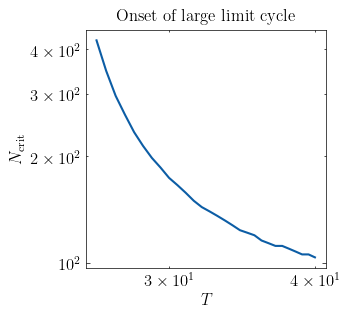

In [164]:
β, ρ = 2, 1

data = readdlm("./data/two-step-kernel/large-lc-death.dat", comments = true)
Ts, N_crits = eachrow(data)

fig, ax = plt.subplots()
ax.set(
    xlabel = L"T", ylabel = L"N_\text{crit}", title = "Onset of large limit cycle",
    xscale = "log",
    yscale = "log",
)
ax.plot(Ts, N_crits)
display(fig)

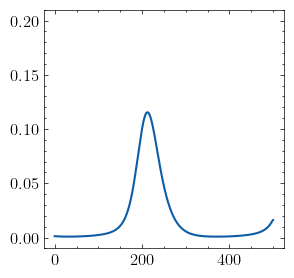

0.01652892561983471, 0.004470780033883253, 0.012058145585951459


In [14]:
β, ρ = 2, 1
sol = solve_erlang_two_step_kernel(β, ρ, 26, 500, 0.01, 6000)
fp = erlang_two_step_kernel_fp(β, ρ, 39)
m = mean(sol[1, end-100:end])
println("$fp, $m, $(abs(fp-m))")
fig, ax = plt.subplots()
ax.set(ylim=(-.01, 0.21))
ax.plot(sol[1, end-500:end])
display(fig)

In [187]:
β, ρ = 2, 1
T = 25.5
fp = erlang_two_step_kernel_fp(β, ρ, T)
found = false
N = 400
while !found
    sol = solve_erlang_two_step_kernel(β, ρ, T, N, 0.01, 6000)
    if abs(mean(sol[1, end-100:end]) - fp) > 1e-5
        found = true
        print(N)
    end
    N += 2
end

556

## Two step kernel delay equation

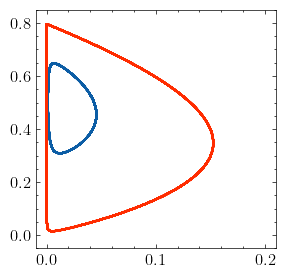

In [84]:
# Implementing delay equation two step model (N -> infty)
function two_step_function_kernel!(
        du::Vector{<:Real}, u::Vector{<:Real},
        h, p, t::Real
    )
    β, ρ, T = p
    du[1] = β * u[1] * (1 - u[1] - u[2]) - ρ * u[1]
    du[2] = ρ * u[1] - ρ/2 * h(p, t-T/2)[1] - ρ/2 * h(p, t-T)[1]
end

fig, ax = plt.subplots()
ax.set(xlim = (-0.01, 0.21), ylim = (-0.05, 0.85))

p = (β, ρ, T) = (2, 1, 50)
t_max = 2000

# I₀ = 0.01
I_fp = erlang_two_step_kernel_fp(β, ρ, T)
R_fp = ρ * I_fp * 3/4 * T
# h(p, t) = t == 0 ? [I₀, 0] : [0.0, 0.0] # infection seeded at t = 0
h(p, t) = [I_fp + 0.0001, R_fp + 0.0001]
sol = solve(
    DDEProblem(two_step_function_kernel!, [I_fp + 0.0001, R_fp + 0.0001], h, (0.0, t_max), p),
    MethodOfSteps(RK4()),
    reltol = 1e-8
)
ax.plot(sol[1, 1000:end], sol[2, 1000:end])

I₀ = 0.01
h(p, t) = t == 0 ? [I₀, 0] : [0.0, 0.0] # infection seeded at t = 0
sol = solve(
    DDEProblem(two_step_function_kernel!, [I₀, 0.0], h, (0.0, t_max), p),
    MethodOfSteps(RK4()),
    reltol = 1e-8
)
ax.plot(sol[1, 1000:end], sol[2, 1000:end])
display(fig)

# General superposition kernel

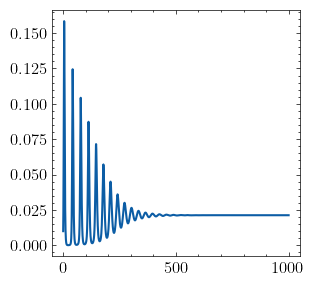

(gen_fp(β, ρ, T, k), sol[1, end]) = (0.02127659574468085, 0.02127652774297993)
λ_max(J) = -0.01605681339885115


-0.01605681339885115

In [7]:
p = (β, ρ, T, N) = (2, 1, 30, 50)
k = 0.5
cₘ(m) = m <= N/2 ? 1 : k
I₀ = 0.01
t_max = 1000
sol = solve_erlang_superpos_kernel(p..., cₘ, I₀, t_max)

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# @show minimum(sol[1, end-1000:end])
display(fig)

gen_fp(β, ρ, T, k) = (2*(β - ρ))/(β*((k + 1)*ρ*T + 2))
@show (gen_fp(β, ρ, T, k), sol[1, end]);

J = erlang_superpos_kernel_jacobian(p..., cₘ, gen_fp(β, ρ, T, k))
@show λ_max(J)